# Recurrent Neural Networks

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28/02/25  | Martin | Created   | Create for chapter 9. Started on text generation section | 
| 02/03/25  | Martin | Update   | Completed text generation with LSTM section | 

# Content

* [Introduction](#introduction)
* [Text Generation - LSTM](#text-generation)
* [Stock Price Prediction](#stock-price-prediction)

# Introduction

__Recurrent Neural Networks (RNN)__ model data that is sequential in nature. Recurrent refers to data where the output of the current step becomes the input to the next one. At each step, the model considers what it has seen about the preceding elements on top of the current input.

__Natural Language Processing (NLP)__ is where we train models to understand text information by training them on the context

Topics covered:

1. Text generation
2. Sentiment classification
3. Time series - stock information
4. Open-domain question answering

---

# Text Generation

Use a _Long Short-Term Memory (LSTM)_ architecture to build a text generation model

* Standard RNN models suffer from long dependencies i.e words that are earlier in the context window no longer contribute to the model since they're further away (vanishing gradient problem).
* LSTM maintains a cell state, and a "carry" to ensure the signal is not loss as the sequence progresses
* Each step: (1) current word (2) carry (3) cell state

Video References

* [RNN Explained](https://www.youtube.com/watch?v=AsNTP8Kwu80&ab_channel=StatQuestwithJoshStarmer)
* [LSTM Explained](https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer)

![LSTM Architecture](./images/lstm_architecture.png)

In [4]:
import tensorflow as tf
import tensorflow.keras as keras

# Keras modules for LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

import numpy as np
np.random.seed(7)
tf.random.set_seed(7)
import random
random.seed(7)
tf.random.uniform([1], seed=1)

import pandas as pd
import string

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

In [12]:
# Define functions that simplify the workflow
def clean_text(txt):
  """
  Removes punctuations and lowercase text.
  Then convert text into utf-8 format
  """
  txt = "".join(v for v in txt if v not in string.punctuation).lower()
  txt = txt.encode('utf8').decode('ascii', 'ignore')
  return txt


def get_sequence_of_tokens(corpus):
  """
  Creates an ngram sequence - a list of lists that contain the tokenised sentences.
  For each sentence, everytime a new word is added to the list, it is added as a new indexed list
  """
  # Tokeniser
  tokeniser.fit_on_texts(corpus)
  total_words = len(tokeniser.word_index) + 1

  # Convert data to sequence of tokens
  input_sequences = []
  for line in corpus:
    token_list = tokeniser.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]
      input_sequences.append(n_gram_sequence)
  return input_sequences, total_words


def generate_padded_sequences(input_sequences):
  """
  1. Ensure that all the sequenes are of the same length by adding padding
  All padding is added to the front
  2. Separate the predictions (text content) and labels (last word in the sequence)
  3. Convert the label into a categorical variable. Categories are all available words
  in the corpus
  """
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(
    input_sequences,
    maxlen=max_sequence_len,
    padding='pre'
  ))

  predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
  label = ku.to_categorical(label, num_classes=total_words)
  return predictors, label, max_sequence_len


def generate_text(seed_text, next_words, model, max_sequence_len):
  """
  1. Add the same preprocessing done to the text
  2. Make predictions of next word
  3. Add the predicted word to the end of the seed text
  """
  for _ in range(next_words):
    # Apply the same preprocessing as the model
    token_list = tokeniser.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences(
      [token_list],
      maxlen=max_sequence_len-1, # need to remove the label
      padding='pre'
    )

    # Make a prediction on the next word
    predicted = model.predict(token_list, verbose=0)
    predicted = np.argmax(predicted, axis=1)

    # Convert the prediction back to actual word
    output_word = ""
    for word, index in tokeniser.word_index.items():
      if index == predicted:
        output_word = word
        break
      
    seed_text += " " + output_word
  
  return seed_text.title()

In [2]:
def create_model(max_sequence_len, total_words):
  input_len = max_sequence_len - 1
  model = Sequential()
  
  # Add Input Embedding Layer
  model.add(Embedding(total_words, 10, input_length=input_len))
  
  # Add Hidden Layer 1 - LSTM Layer
  model.add(LSTM(100))
  
  # Add Output Layer
  model.add(Dense(total_words, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam')
  
  return model

## Loading Data

In [5]:
directory = "../data/nyt_articles/"
all_headlines = []
for f in os.listdir(directory):
  article_df = pd.read_csv(directory + f)
  all_headlines.extend(list(article_df.headline.values))

all_headlines[:10]

['Finding an Expansive View  of a Forgotten People in Niger',
 'And Now,  the Dreaded Trump Curse',
 'Venezuela’s Descent Into Dictatorship',
 'Stain Permeates Basketball Blue Blood',
 'Taking Things for Granted',
 'The Caged Beast Awakens',
 'An Ever-Unfolding Story',
 'O’Reilly Thrives as Settlements Add Up',
 'Mouse Infestation',
 'Divide in G.O.P. Now Threatens Trump Tax Plan']

Perform data preparation steps:

1. Remove punctuations and lower casing of all words
2. _Tokenisation:_ Converting text into ngram sequences - _ngrams_ are lists of integers that encode the word from a standard corpus based on the index
3. _Padding:_ Ensures that all the sequences are of the same length
4. Create the predictors and labels: labels are just the next word in the sequence

📜 __NOTE:__ Language modeling requires a sequence input data, as given a squence (of words/ tokens) the aim is the prediction of the next word/ token

In [6]:
# 1. Removing punctuations, lower casing
corpus = [clean_text(x) for x in all_headlines]
corpus[:10]

['finding an expansive view  of a forgotten people in niger',
 'and now  the dreaded trump curse',
 'venezuelas descent into dictatorship',
 'stain permeates basketball blue blood',
 'taking things for granted',
 'the caged beast awakens',
 'an everunfolding story',
 'oreilly thrives as settlements add up',
 'mouse infestation',
 'divide in gop now threatens trump tax plan']

In [7]:
# 2. Tokenisation for ngram sequences
tokeniser = Tokenizer()

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[392, 18],
 [392, 18, 5167],
 [392, 18, 5167, 524],
 [392, 18, 5167, 524, 4],
 [392, 18, 5167, 524, 4, 2],
 [392, 18, 5167, 524, 4, 2, 1602],
 [392, 18, 5167, 524, 4, 2, 1602, 135],
 [392, 18, 5167, 524, 4, 2, 1602, 135, 5],
 [392, 18, 5167, 524, 4, 2, 1602, 135, 5, 1952],
 [7, 58]]

In [8]:
# 3 + 4. Padding sequences + create labels
predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

## The model

In [9]:
model = create_model(max_sequence_len, total_words)
model.summary()

d:\Software\venv\py311_env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(predictors, label, epochs=100)

Epoch 1/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 8.0648
Epoch 2/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.2458
Epoch 3/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 6.9820
Epoch 4/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 6.7311
Epoch 5/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 6.5441
Epoch 6/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 6.3928
Epoch 7/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 6.3411
Epoch 8/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 6.1625
Epoch 9/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 6.0941
Epoch 10/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 5.9482
Epoch 11/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 5.9086
Epoch 12/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 5.7353
Epoch 13/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 5.7219
Epoch 14/100
1618/1618 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 5.5235

Testing the model

In [13]:
print (generate_text("united states", 5, model, max_sequence_len))
print (generate_text("united states", 10, model, max_sequence_len))
print (generate_text("united states", 15, model, max_sequence_len))

United States To Make For Trump Starts
United States To Make For Trump Starts In Champions And Eye In
United States To Make For Trump Starts In Champions And Eye In Coup Gets Midterm Control But


In [14]:
print (generate_text("president trump", 3, model, max_sequence_len))
print (generate_text("president trump", 4, model, max_sequence_len))
print (generate_text("president trump", 5, model, max_sequence_len))
print (generate_text("president trump", 8, model, max_sequence_len))

President Trump Fails Another Rivals
President Trump Fails Another Rivals Period
President Trump Fails Another Rivals Period Without
President Trump Fails Another Rivals Period Without Marathon Of Mls


In [15]:
print (generate_text("joe biden", 3, model, max_sequence_len))
print (generate_text("joe biden", 4, model, max_sequence_len))
print (generate_text("joe biden", 5, model, max_sequence_len))
print (generate_text("joe biden", 8, model, max_sequence_len))

Joe Biden Who Out In
Joe Biden Who Out In A
Joe Biden Who Out In A New
Joe Biden Who Out In A New Foster Child Said


In [16]:
print (generate_text("india and china", 3, model, max_sequence_len))
print (generate_text("india and china", 4, model, max_sequence_len))
print (generate_text("india and china", 5, model, max_sequence_len))
print (generate_text("india and china", 8, model, max_sequence_len))

India And China Republicans Sex Abuse
India And China Republicans Sex Abuse May
India And China Republicans Sex Abuse May Reject
India And China Republicans Sex Abuse May Reject Trumps Wiretapping But


In [17]:
print (generate_text("european union", 3, model, max_sequence_len))
print (generate_text("european union", 4, model, max_sequence_len))
print (generate_text("european union", 5, model, max_sequence_len))
print (generate_text("european union", 8, model, max_sequence_len))

European Union Disaster May Be
European Union Disaster May Be Greater
European Union Disaster May Be Greater Son
European Union Disaster May Be Greater Son In The Garden


---

# Skipping Sentiment Classification

---

# Stock Price Prediction

Sequential models (RNNs) are well suited for time series  predictions, since they can capture the impact of earlier values to apply them to the current time frame

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler

In [25]:
# Define the model
def create_model(nunits: int):
  regressor = Sequential()

  # 1 LSTM layer
  regressor.add(LSTM(
    units=nunits,
    activation='sigmoid',
    input_shape=(None, 1)
  ))

  # Output layer - 1 unit for the next price prediction
  regressor.add(Dense(units=1))

  # Compiling the RNN
  regressor.compile(optimizer='adam', loss='mean_squared_error')

  return regressor

## Data

In [18]:
df = pd.read_csv("../data/btcusd_1-min_data.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [23]:
df['date'] = pd.to_datetime(df['Timestamp'], unit='s').dt.date
group = df.groupby('date')
real_price = group['Open'].mean()
real_price.head()

date
2012-01-01    4.645697
2012-01-02    4.975000
2012-01-03    5.085500
2012-01-04    5.170250
2012-01-05    5.954292
Name: Open, dtype: float64

In [28]:
# Split data
prediction_days = 30
df_train = real_price[:len(real_price)-prediction_days]
df_test = real_price[len(real_price)-prediction_days:]

# Data preprocessing
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [29]:
# Initialising the RNN
regressor = create_model(nunits=4)

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100


d:\Software\venv\py311_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 0.0926
Epoch 2/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.0294
Epoch 3/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.0146
Epoch 4/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.0034
Epoch 5/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - loss: 2.5302e-04
Epoch 6/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - loss: 8.6375e-05
Epoch 7/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 8.5825e-05
Epoch 8/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - loss: 8.5778e-05
Epoch 9/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 614us/step - loss: 8.5623e-05
Epoch 10/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - loss: 8.5386e-05
Epoch 11/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 8.4838e-05
Epoch 12/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - loss: 8.4033e-05
Epoch 13/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 8.3132e-05
Epoch 14/100
956/956 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - loss

In [30]:
# Making the predictions
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


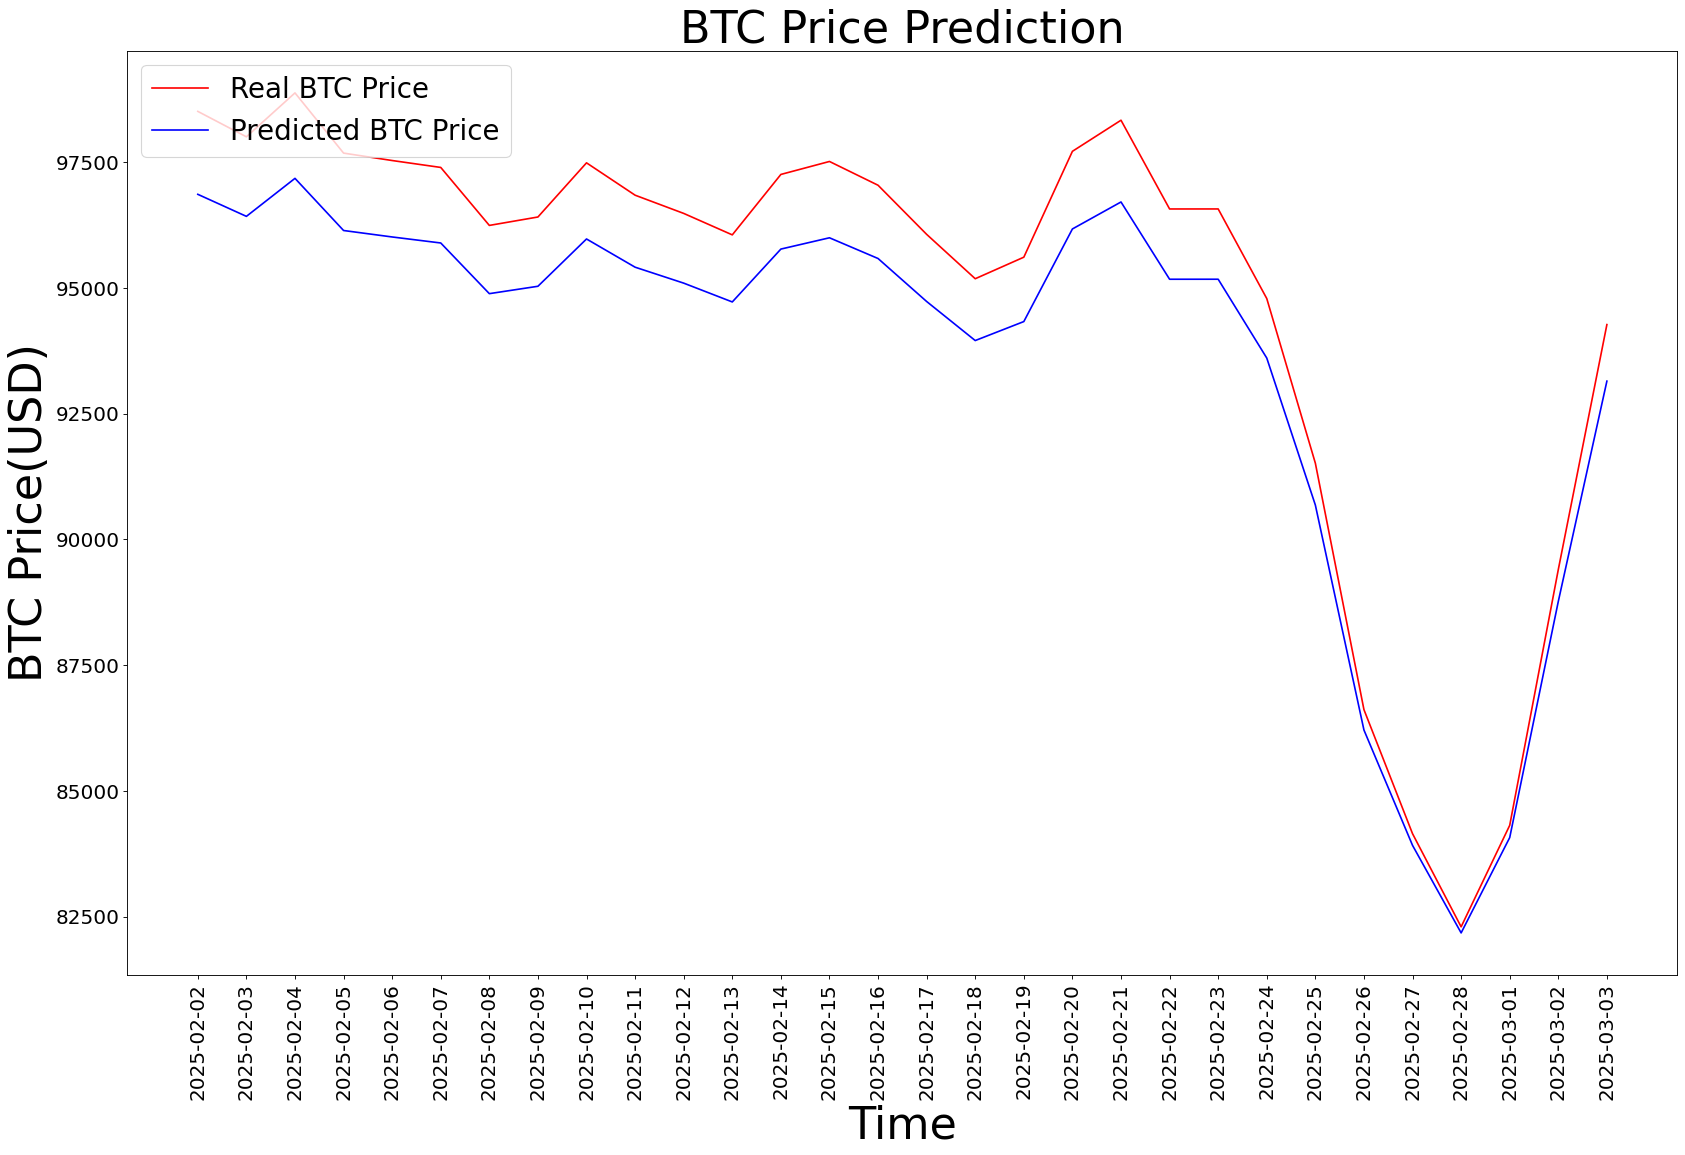

In [31]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
# plt.savefig('B16254_09_03_KB300.png', dpi = 300, bbox_inches = "tight")
# plt.savefig('B16254_09_03_KB450.png', dpi = 450, bbox_inches = "tight")
# plt.savefig('B16254_09_03_KB600.png', dpi = 600, bbox_inches = "tight")
plt.show()

## Model Review

* Using todays values to predict tomorrow -> Tomorrow's values doesn't exist yet
* Take note of what values are being fed into the NN - NN here is learning just the same trend as what was shown but might not always be the case